In [1]:
import Interface as I
from neuron import h

from getting_started import getting_started_dir, tutorial_output_dir

current_dir = '/Users/robinweiler/Documents/PhD/Project/Code/ISF/in_silico_framework/robinweiler'
print(current_dir)

db = I.DataBase(I.os.path.join(current_dir, 'results'))
db = db.create_sub_db('GB_opt')

client = I.get_client(client_ip='localhost', client_port=8786)

[ATTENTION] distributed_lock: Environment variable ISF_DISTRIBUTED_LOCK_CONFIG is not set. Falling back to default configuration.
[INFO] distributed_lock: trying to connect to distributed locking server {'type': 'redis', 'config': {'host': 'spock', 'port': 8885, 'socket_timeout': 1}}
[INFO] distributed_lock: trying to connect to distributed locking server {'type': 'redis', 'config': {'host': 'localhost', 'port': 6379, 'socket_timeout': 1}}
[INFO] distributed_lock: trying to connect to distributed locking server {'type': 'file'}
[WARNING] distributed_lock: Using file based locking. Please be careful on nfs mounts as file based locking has issues in this case.
[INFO] l5pt: Loading mechanisms:
[INFO] ISF: Current version: heads/develop+0.gb90ea5f4.dirty
[INFO] ISF: Current pid: 32927


--No graphics will be displayed.


[ATTENTION] ISF: The source folder has uncommited changes!
[WARNING] ISF: Could not load linked views



[INFO] ISF: Loaded modules with __version__ attribute are:
IPython: 8.12.2, Interface: heads/develop+0.gb90ea5f4.dirty, PIL: 9.2.0, _brotli: 1.1.0, _csv: 1.0, _ctypes: 1.1.0, _curses: b'2.2', _decimal: 1.70, appnope: 0.1.4, argparse: 1.1, async_timeout: 5.0.1, backcall: 0.2.0, blosc: 1.11.1, bluepyopt: 1.9.126, brotli: 1.1.0, certifi: 2024.08.30, cffi: 1.17.0, charset_normalizer: 3.4.0, click: 7.1.2, cloudpickle: 3.1.0, colorama: 0.4.6, comm: 0.2.2, csv: 1.0, ctypes: 1.1.0, cycler: 0.12.1, cytoolz: 0.12.3, dash: 2.18.2, dask: 2.30.0, dateutil: 2.9.0, deap: 1.4, debugpy: 1.8.5, decimal: 1.70, decorator: 5.1.1, defusedxml: 0.7.1, distributed: 2.30.1, distutils: 3.8.20, django: 1.8.19, entrypoints: 0.4, executing: 2.1.0, fasteners: 0.17.3, flask: 1.1.4, fsspec: 2024.10.0, future: 1.0.0, greenlet: 3.1.1, idna: 3.10, ipaddress: 1.0, ipykernel: 6.29.5, ipywidgets: 8.1.5, itsdangerous: 1.1

# Load optimized model

In [2]:
if not 'biophysical_constraints' in db.keys():
    cell_parameter_file = I.os.path.join(
        getting_started_dir, 
        'example_data',
        'biophysical_constraints', 
        '86_CDK_20041214_BAC_run5_soma_Hay2013_C2center_apic_rec.param')
    I.shutil.copy(cell_parameter_file, db.create_managed_folder('biophysical_constraints'))

cell_parameter_file = db['biophysical_constraints'].join('86_CDK_20041214_BAC_run5_soma_Hay2013_C2center_apic_rec.param')

In [3]:
from sumatra.parameters import NTParameterSet

cell_params = NTParameterSet(cell_parameter_file)
cell = I.scp.create_cell(cell_params.neuron)

In [4]:
iclamp = h.IClamp(0.5, sec=cell.soma)
iclamp.delay = 150 # [ms] give the cell time to reach steady state
iclamp.dur = 5 # [ms] rectangular pulse
iclamp.amp = 1.9 # [nA]
%time I.scp.init_neuron_run(cell_params.sim, vardt=True) # run the simulation 

CPU times: user 234 ms, sys: 3.02 ms, total: 237 ms
Wall time: 240 ms


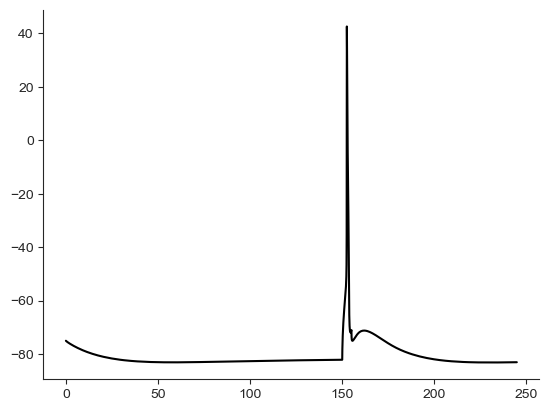

In [5]:
%matplotlib inline
I.sns.set_style('ticks')
I.plt.plot(cell.tVec, cell.soma.recVList[0], c = 'k');
I.sns.despine()

# Create GB-synapse

## Presynaptic input

In [6]:
from single_cell_parser.cell import PointCell

presynaptic_cell = PointCell([200])

## Postsynaptic location

In [7]:
def get_section_at_distance(cell, dist, sec_dist_dict):
    dummy = {k - dist: v for k,v in sec_dist_dict.items() if k > dist}
    closest_sec = dummy[min(dummy)]
    x = (dist - cell.distance_to_soma(closest_sec, 0.0)) / closest_sec.L
    return x, closest_sec

In [8]:
# map between sections and somadistance
sec_dist_dict = {cell.distance_to_soma(sec, 1.0): sec for sec in cell.sections}
# print(sec_dist_dict)

sec_at_100 = get_section_at_distance(cell, 100, sec_dist_dict)
print(sec_at_100)

syn_sec = sec_at_100[1]
syn_seg_id = len(syn_sec.pts) // 2

(0.9294685090584054, __nrnsec_0x1301025e0)


In [9]:
syn_sec_id = [i for i in range(len(cell.sections)) if cell.sections[i] == syn_sec][0]

## Create synapse

In [10]:
from robinweiler.GB_synapse import GBSynapse
from single_cell_parser.synapse import ExSyn

gb_synapse = GBSynapse(syn_sec_id, syn_seg_id)
gb_synapse.activate_hoc_syn(source=presynaptic_cell, targetCell=cell)

NEURON: if arg 1 is an object it must be a point process or NULLObject
 near line 0
 while (t < tstop) { fadvance() }
                                 ^
        NetCon(..., ..., 10, 0, 1)


RuntimeError: hocobj_call error

In [ ]:
%time I.scp.init_neuron_run(cell_params.sim, vardt=True) # run the simulation

In [ ]:
%matplotlib inline
I.sns.set_style('ticks')
I.plt.plot(cell.tVec, cell.soma.recVList[0], c = 'k');
I.sns.despine()

In [ ]:
break

## Parameters to optimize

In [ ]:
synapse_params = {    
    "synapses": {
        "receptors": {
            'GBSynapse': {
                'delay': 0.0,
                'parameter': {
                    'gamma_d_GB': [1, 300],
                    'gamma_p_GB': [1, 300],
                    'theta_d_GB': [0.1, 10],
                    'theta_p_GB': [0.1, 10],
                    'tau_effca_GB': [100, 400],
                },
                'threshold': 0.0,
                'weight': 1.0
            }
        }
    }
}

# Database setup

In [ ]:
from biophysics_fitting.GBSynapse_parameter_setup import get_GBSynapse_template
import biophysics_fitting.GBSynapse_setup as GBSynapse_setup


def get_fixed_params(db_setup):
    """
    Configure the fixed params and return
    """
    fixed_params = db_setup['fixed_params']
    fixed_params['morphology.filename'] = db_setup['morphology'].get_file(
        'hoc')
    return fixed_params

def get_Simulator(db_setup, step=False):
    """
    Configure the Simulator object and return
    """
    fixed_params = db_setup['get_fixed_params'](db_setup)
    s = GBSynapse_setup.get_Simulator(
        I.pd.Series(fixed_params),
        step=step
    )
    s.setup.cell_param_generator = get_GBSynapse_template

    return s

def get_Evaluator(db_setup, step=False):
    """
    No additional configuration is needed for the Evaluator, simply return biophysics_fitting.L5tt_parameter_setup.get_Evaluator
    """
    return GBSynapse_setup.get_Evaluator(step=step)

def get_Combiner(db_setup, step=False):
    """
    No additional configuration is needed for the Combiner, simply return biophysics_fitting.L5tt_parameter_setup.get_Combiner
    """
    return GBSynapse_setup.get_Combiner(step=step)

In [ ]:
def set_up_db_for_MOEA(db, morphology_id='89', morphology="", step=False):
    """
    Set up a DataBase for MOEA.

    Args:
        db: a DataBase object
        morphology_id: name of the morphology
        morphology: path to a .hoc morphology file
        step: whether or not to perform step current injections

    Returns:
        data_base.DataBase: a database containing:
            - fixed_params
            - get_fixed_params
            - get_Simulator
            - get_Evaluator
            - get_Combiner
            - the morphology file
    """
    from data_base.IO.LoaderDumper import pandas_to_pickle, to_cloudpickle
    db.create_sub_db(morphology_id)

    db[morphology_id].create_managed_folder('morphology', raise_=False)
    I.shutil.copy(
        I.os.path.join(
            morphology
        ), db[morphology_id]['morphology'].join(
            morphology.split(I.os.sep)[-1]
        )
    )

    db[morphology_id]['fixed_params'] = {
        'LTP.measure.recSite': 100,   # recording site on the apical dendrite for BAC
        'hot_zone.min_': 384.8203371921156,             # calcium zone start
        'hot_zone.max_': 584.8203371921156,             # calcium zone end
        'hot_zone.outsidescale_sections': [23,24,25,26,27,28,29,31,32,33,34,35,37,38,40,42,43,44,46,48,50,51,52,54,56,58,60],
        'morphology.filename': None
    }

    db[morphology_id]['get_fixed_params'] = get_fixed_params
    db[morphology_id].set('params', params, dumper=pandas_to_pickle)
    db[morphology_id].set('get_Simulator',
                      I.partial(get_Simulator, step=step),
                      dumper=to_cloudpickle)
    db[morphology_id].set('get_Evaluator',
                      I.partial(get_Evaluator, step=step),
                      dumper=to_cloudpickle)
    db[morphology_id].set('get_Combiner',
                      I.partial(get_Combiner, step=step),
                      dumper=to_cloudpickle)

    return db

In [ ]:
db = set_up_db_for_MOEA(
    db,
    morphology_id="89",
    morphology=morphology_path,
    step=False
)
db.ls(max_lines_per_key=10)

# Run the optimization algorithm

In [ ]:
seedpoint = 42

population = I.bfit_start_run(
    db['89'], 
    n=seedpoint,
    client=client, 
    offspring_size=10,      # Low amount of offspring just as an example 
    pop=None,               # adapt this to the output population of the previous run to continue where you left off
    continue_cp=False,      # If you want to continue a preivoius run, set to True
    max_ngen=100            # run for just 1 generation
)

In [ ]:
population = db['89'][str(seedpoint)]['1']
objectives = population.drop(params.index, axis=1)
objectives

In [ ]:
%matplotlib inline
I.plt.style.use("fivethirtyeight")
diff = (objectives - empirical_data['mean']) / empirical_data["std"]
ax = diff.plot.box(vert=False)
ax.set_xscale('log')
ax.set_xlabel("amount of $\sigma$ from empirical mean")

# Exploration from seedpoint

In [ ]:
if not I.os.path.exists(I.os.path.join(db["89"].basedir, 'RW_exploration_example')):
    db["89"].create_managed_folder('RW_exploration_example')

We provide some working models for this morphology below. 

In [ ]:
model_db = I.DataBase(I.os.path.join(getting_started_dir, "example_data", "simulation_data", "biophysics"))

model_db["example_models"]

### Setup the random walk exploration

there are many different kinds of exploration one could do. We will simply use a random walk, as it has proven to be both efficient and capable of broadly sampling the bipohysical parameter space.

In [ ]:
evaluator = db["89"]["get_Evaluator"](db['89'])
simulator = db["89"]["get_Simulator"](db['89'])
biophysical_parameter_ranges = db['89']['params']
example_models = model_db['example_models']
biophysical_parameter_names = [e for e in example_models.columns if "ephys" in e or e == "scale_apical.scale"]

In [ ]:
from biophysics_fitting.exploration_from_seedpoint.RW import RW
from biophysics_fitting.exploration_from_seedpoint.utils import evaluation_function_incremental_helper
from biophysics_fitting.hay_evaluation import hay_evaluate_bAP, hay_evaluate_BAC

evaluation_function = I.partial(
    evaluation_function_incremental_helper,  # this incremental helper stops the evaluation as soon as a stimulus protocol doesn't work.
    s=simulator,
    e=evaluator,
    stim_order=['bAP', 'BAC']
)

rw = RW(
    param_ranges = biophysical_parameter_ranges,
    df_seeds = example_models[biophysical_parameter_names],
    evaluation_function = evaluation_function,
    MAIN_DIRECTORY = db["89"]['RW_exploration_example'],
    min_step_size = 0.02,
    max_step_size = 0.02,
    checkpoint_every = 1  # This is a lot of IO. Increase this value if you are not merely doing an example.
)

### Run the exploration algorithm

Let's run this for 20 seconds. You can always restart the exploration and it will pick up from where it left off. 

In [ ]:
duration = 30  # in seconds

from time import sleep
from threading import Thread
import multiprocessing

proc = multiprocessing.Process(
    target=rw.run_RW, 
    kwargs={
        'selected_seedpoint': 0,
        'particle_id': 0,
        'seed': 42  # for numpy random seed
    })

# --- run for some time, then kill the process
proc.start()
sleep(duration)
proc.terminate()  # sends a SIGTERM
proc.join()

In [ ]:
from biophysics_fitting.exploration_from_seedpoint.RW_analysis import Load

outdir = db["89"]['RW_exploration_example'].join('0')
l = Load(
    client,
    outdir,
    n_particles = 1)

In [ ]:
explored_models = l.get_df().compute()
print("Explored {} new models".format(len(explored_models)))

### Inspecting the exploration results

How much did the exploration actually explore? Let's plot out how much it deviated from it's starting point, relative to the total extent of parameter limits we allowed for

In [ ]:
def normalize(df, mn, mx):
    return (df - mn)/(mx-mn)
    
mn, mx = biophysical_parameter_ranges['min'], biophysical_parameter_ranges['max']
normalized_startpoint = normalize(example_models.iloc[0][biophysical_parameter_names], mn, mx)
normalized_explored_models = normalize(explored_models[biophysical_parameter_names], mn, mx)

# calc exploration relative to startpoint, in % of total allowed parameter limits
d = I.pd.concat([normalized_explored_models, I.pd.DataFrame(normalized_startpoint).T])
d -= normalized_startpoint
d[biophysical_parameter_names] *= 100
d = d.melt(var_name='Biophysical parameter', value_name='Normalized value (%)')

In [ ]:
I.plt.figure(figsize=(5, 10))

ax = I.sns.boxplot(
    data=d,
    y='Biophysical parameter', x='Normalized value (%)',
    whis=100,
    linewidth=1,
    showcaps = False
   )

Let's check what the resulting voltage traces look like

In [ ]:
delayeds = [
    I.dask.delayed(simulator.run)(p, 'BAC') 
    for _, p in explored_models[biophysical_parameter_names].iterrows()
    ]
f = client.compute(delayeds)

In [ ]:
responses = [f_.result() for f_ in f]
BAC_responses = [response['BAC.hay_measure'] for response in responses]

In [ ]:
soma_voltages = [
    e['vList'][0] for e in BAC_responses
]
dend_voltages = [
    e['vList'][1] for e in BAC_responses
]
time_points = [
    e['tVec'] for e in BAC_responses
]

In [ ]:
fig, (ax1, ax2) = I.plt.subplots(1, 2, figsize=(15, 5))
colors = I.plt.rcParams['axes.prop_cycle'].by_key()['color']                       
random_model = I.np.random.randint(0, len(BAC_responses))
print("Highlighting model nr. {}".format(random_model))

for t, v in zip(time_points, soma_voltages):
    ax1.plot(t, v, c="silver", lw=3)
ax1.plot(
    time_points[random_model], 
    soma_voltages[random_model], 
    c=colors[0],
    lw=2
    )
ax1.set_title("Soma voltage")
ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("Membrane voltage (mV)")

for t, v in zip(time_points, dend_voltages ):
    ax2.plot(t, v, c='silver', lw=3)
ax2.plot(
    time_points[random_model], 
    dend_voltages[random_model], 
    c=colors[1],
    lw=2
    )
ax2.set_title("Dendritic voltage")
ax2.set_xlabel("Time (ms)")
I.plt.show()

In [ ]:
cell, _ = simulator.get_simulated_cell(
    explored_models[biophysical_parameter_names].iloc[random_model], 
    "BAC")

In [ ]:
from visualize.cell_morphology_visualizer import CellMorphologyVisualizer as CMV

CMV(
    cell,
    t_start=250,
    t_stop=400,
    t_step=1,
    ).animation(
    images_path=db.basedir+'/images',
    color="voltage",
    client=client,
    show_legend=True
)